# Healthcare Infrastructure

In this notebook, we will perform a **damage and risk assessment** for healthcare infrastructure. The assessment is based on combining hazard data (e.g., flood depths) with vulnerability curves to estimate the potential damage to infrastructure.

We will follow the steps outlined below to conduct the assessment:

1. **Loading the necessary packages:**  
   We will import the Python libraries required for data handling, analysis, and visualization.

2. **Loading the data:**  
   The infrastructure data (e.g., hospitals) and hazard data (e.g., flood depths) will be loaded into the notebook.

3. **Preparing the data:**  
   The infrastructure and hazard data will be processed and data gaps can be filled, if required.

4. **Performing the damage assessment:**  
   We will apply vulnerability curves to estimate the potential damage based on the intensity of the hazard.

5. **Visualizing the results:**  
   Finally, we will visualize the estimated damage using graphs and maps to illustrate the impact on healthcare infrastructure.

## 1. Loading the Necessary Packages
To perform the assessment, we are going to make use of several [python packages](https://docs.python.org/3/tutorial/modules.html#packages).

In case you run this in Google Colab, you will have to install the packages below **(remove the hashtag in front of them)**.

In [1]:
#!pip install damagescanner==0.9b13
#!pip install contextily
#!pip install exactextract
#!pip install lonboard

In this step, we will import all the required Python libraries for data manipulation, spatial analysis, and visualization.

In [2]:
import warnings
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import shapely

import matplotlib.pyplot as plt
import contextily as cx

import damagescanner.download as download
from damagescanner.core import DamageScanner
from damagescanner.osm import read_osm_data, DICT_CIS_OSM, extract,_extract_value
from damagescanner.base_values import DICT_CIS_VULNERABILITY_FLOOD

from lonboard import viz

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning) # exactextract gives a warning that is invalid

### Specify the country of interest

Before we continue, we should specify the country for which we want to assess the damage. We use the ISO3 code for the country to download the OpenStreetMap data.

In [3]:
country_full_name = 'Moldova'
country_iso3 = 'MDA'

## 2. Loading the Data
In this step, we will load four key datasets:

1. **Infrastructure data:**  
   This dataset contains information on the location and type of healthcare infrastructure (e.g., hospitals). Each asset may have attributes such as type, length, and replacement cost.

2. **Hazard data:**  
   This dataset includes information on the hazard affecting the infrastructure (e.g., flood depth at various locations).

3. **Vulnerability curves:**  
   Vulnerability curves define how the infrastructure's damage increases with the intensity of the hazard. For example, flood depth-damage curves specify how much damage occurs for different flood depths.

### Infrastructure Data

We will perform this example analysis for Jamaica. To start the analysis, we first download the OpenStreetMap data from GeoFabrik. 

In [28]:
infrastructure_path = download.get_country_geofabrik(country_iso3)

Now we load the data and read only the healthcare data.

In [29]:
%%time
features = read_osm_data(infrastructure_path,asset_type='healthcare')

CPU times: total: 49.6 s
Wall time: 1min 3s


In [6]:
sub_types = features.object_type.unique()

In [7]:
sub_types

array(['pharmacy', 'clinic', 'doctors', 'dentist', 'laboratory',
       'hospital', 'alternative', 'physiotherapist', 'rehabilitation'],
      dtype=object)

And we can explore our data interactively 

In [8]:
viz(features)

Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…

### Hazard Data
For this example, we make use of the flood data provided by [CDRI](https://giri.unepgrid.ch/map?list=explore).

We use a 1/100 flood map to showcase the approach.

In [9]:
hazard_map = xr.open_dataset("https://hazards-data.unepgrid.ch/global_pc_h100glob.tif", engine="rasterio")

In [10]:
hazard_map

<xarray.Dataset> Size: 747GB
Dimensions:      (band: 1, x: 432000, y: 216000)
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 3MB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 2MB 90.0 90.0 90.0 90.0 ... -90.0 -90.0 -90.0 -90.0
    spatial_ref  int32 4B ...
Data variables:
    band_data    (band, y, x) float64 746GB ...

### Vulnerability data
Similarly to the maximum damages, specifying the vulnerability curves is complex. We generally have limited information about the quality of the assets, its level of deteriation and other asset-level characteristics.

In [14]:
vulnerability_path = "https://zenodo.org/records/10203846/files/Table_D2_Multi-Hazard_Fragility_and_Vulnerability_Curves_V1.0.0.xlsx?download=1"
vul_df = pd.read_excel(vulnerability_path,sheet_name='F_Vuln_Depth')

And let's have a look at all the available options

In [15]:
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
  display(vul_df.iloc[:2,:].T)

,0,1
ID number,Infrastructure description,Additional characteristics
F1.1,plant,"Small power plants, capacity <100 MW"
F1.2,plant,"Medium power plants, capacity 100-500 MW"
F1.3,plant,"Large power plants, >500 MW"
F1.4,plant,thermal plant
F1.5,plant,wind turbine
F1.6,plant,wind turbine
F1.7,plant,wind turbine
F2.1,substation,Low Voltage Substation
F2.2,substation,Medium Voltage Substation


And select a curve to use for each different subtype we are analysing.

In [16]:
sub_types

array(['pharmacy', 'clinic', 'doctors', 'dentist', 'laboratory',
       'hospital', 'alternative', 'physiotherapist', 'rehabilitation'],
      dtype=object)

In [17]:
selected_curves = dict(zip(sub_types,['F21.1','F21.1','F21.2','F21.1','F21.2','F21.3','F21.1','F21.1','F21.1']))

The next step is to extract the curves from the database, and prepare them for proper usage into our analysis.

We start by selecting the curve IDs from the larger pandas DataFrame **vul_df**:

In [18]:
damage_curves = vul_df[['ID number']+list(selected_curves.values())]
damage_curves = damage_curves.iloc[4:125,:]

Then for convenience, we rename the index name to the hazard intensity we are considering. 

In [19]:
damage_curves.set_index('ID number',inplace=True)
damage_curves.index = damage_curves.index.rename('Depth')  

And make sure that our damage values are in floating numbers. 

In [20]:
damage_curves = damage_curves.astype(np.float32)

And ensure that the columns of the curves link back to the different asset types we are considering:

In [21]:
damage_curves.columns = sub_types

There could be some **NaN** values at the tail of some of the curves. To make sure the code works, we fill up the **NaN** values with the last value of each of the curves. 

In [22]:
damage_curves = damage_curves.fillna(method='ffill')

Finally, make sure we set the index of the damage curves (the inundation depth) in the same metric as the hazard data (e.g. meters or centimeters).

In [23]:
damage_curves.index = damage_curves.index*100

### Ancilliary data for processing

In [24]:
world = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_0_countries.shp")
world_plot = world.to_crs(3857)

In [25]:
admin1 = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_1_states_provinces.shp")

## 3. Preparing the Data

Clip the hazard data to the country of interest.

In [26]:
country_bounds = world.loc[world.ADM0_ISO == country_iso3].bounds
country_geom = world.loc[world.ADM0_ISO == country_iso3].geometry

In [27]:
hazard_country = hazard_map.rio.clip_box(minx=country_bounds.minx.values[0],
                     miny=country_bounds.miny.values[0],
                     maxx=country_bounds.maxx.values[0],
                     maxy=country_bounds.maxy.values[0]
                    )

### Split data by geometry type

Similarly to some of the **power** and **education** object data, the healthcare data also contains multiple geometry types per unique object type. Instead of converting all data into the same geometry type, here we split the analysis into performing it for *Point* data, and for *Polygon* data. To do so, we need to take several steps:

1. Split the data by geometry type.
2. Define our maximum damages by geometry type.

Let's first get an overview of the different geometry types for all the assets we are considering in this analysis:

In [30]:
features['geom_type'] = features.geom_type
features.groupby(['object_type','geom_type']).count()['geometry']

object_type      geom_type   
alternative      Point             2
clinic           MultiPolygon     62
                 Point           196
dentist          MultiPolygon      6
                 Point           201
doctors          MultiPolygon     14
                 Point            86
hospital         MultiPolygon    277
                 Point            64
                 Polygon           1
laboratory       MultiPolygon      1
                 Point            25
pharmacy         MultiPolygon     37
                 Point           818
physiotherapist  Point             1
rehabilitation   MultiPolygon      2
Name: geometry, dtype: int64

Now we will create a dictionary, where we store the data by geometry type.

In [51]:
feature_split = {}

In [52]:
feature_split['Polygons'] = features.loc[features.geometry.geom_type.isin(['Polygon','MultiPolygon'])]
feature_split['Points'] = features.loc[features.geometry.geom_type.isin(['Point'])]

### Maximum damages
We just identified that locations of healthcare facilities are (somewhat randomly) geotagged as either *Points* or *Polygons*. This matters quite a lot for the maximum damages. For *Polygons*, we would use damage per square meter, whereas for *Points*, we would estimate the damage to the entire asset at once. As such, we will create two maximum damages dataframes: One with damage per square meter, and one per facility.

In [40]:
maxdam_by_geom_type = {}

#### Maximum damage per square meter

In [41]:
maxdam_dict = {'clinic' : 1000, 
               'dentist' : 1000, 
               'laboratory' : 1000, 
               'doctors' : 1000, 
               'pharmacy' : 1000,
               'hospital' : 1000,
               'alternative' : 1000, 
              'physiotherapist': 1000,
                'rehabilitation': 1000,
 }

To be used in our damage assessment, we convert this to a Pandas DataFrame

In [42]:
maxdam = pd.DataFrame.from_dict(maxdam_dict,orient='index').reset_index()
maxdam.columns = ['object_type','damage']

And check if any of the objects are missing from the dataframe.

In [43]:
missing = set(sub_types) - set(maxdam.object_type)

if len(missing) > 0:
    print(f"Missing object types in maxdam: \033[1m{', '.join(missing)}\033[0m. Please add them before you continue.")

In [45]:
maxdam_by_geom_type['Polygons'] = maxdam

#### Maximum damage per facility
And now we define the maximum damages per facility. Please note that these are arbitrary values again, just for the sake of this example. 

In [46]:
maxdam_dict = {'clinic' : 1e6, 
               'dentist' : 5e5, 
               'laboratory' : 2e6, 
               'doctors' : 5e5, 
               'pharmacy' : 1e6,
               'hospital' : 10e6,
               'alternative' : 2.5e5, 
              'physiotherapist': 2.5e5,
                'rehabilitation': 1e6,
 }

To be used in our damage assessment, we convert this to a Pandas DataFrame

In [47]:
maxdam = pd.DataFrame.from_dict(maxdam_dict,orient='index').reset_index()
maxdam.columns = ['object_type','damage']

And check if any of the objects are missing from the dataframe.

In [48]:
missing = set(sub_types) - set(maxdam.object_type)

if len(missing) > 0:
    print(f"Missing object types in maxdam: \033[1m{', '.join(missing)}\033[0m. Please add them before you continue.")

In [49]:
maxdam_by_geom_type['Points'] = maxdam

## 4. Performing the Damage Assessment
We will use the DamageScanner approach. This is a fully optimised damage calculation method, that can capture a wide range of inputs to perform a damage assessment. Here we will run the analysis twice. Once with the *Polygon* data, and once with the *Point* data.

In [53]:
%%time
damage_results_points = DamageScanner(hazard_country, feature_split['Points'], damage_curves, maxdam_by_geom_type['Points']).calculate()

Calculating damage: 100%|███████████████████████████████████████████████████████| 1393/1393 [00:00<00:00, 11789.91it/s]

CPU times: total: 375 ms
Wall time: 1.48 s


In [54]:
%%time
damage_results_polygons = DamageScanner(hazard_country, feature_split['Polygons'], damage_curves, maxdam_by_geom_type['Polygons']).calculate()

Calculating damage: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 7743.93it/s]

CPU times: total: 1.42 s
Wall time: 2.09 s


And now merge all the objects with damage. The *Points* damage estimates works slightly different, and returns all assets, also the non-damaged onces. Here we are mostly interested in all the damaged assets.

In [61]:
damage_results = pd.concat([damage_results_polygons,damage_results_points.loc[damage_results_points.damage > 0]])

## 5. Save the Results
For further analysis, we can save the results in their full detail, or save summary estimates per subnational unit 

In [62]:
hazard = 'river_flood'
return_period = '1_100'
damage_results.to_file(f'Healthcare_Damage_{country_full_name}_{hazard}_{return_period}.gpkg')

In [63]:
admin1_country = admin1.loc[admin1.sov_a3 == country_iso3]

In [64]:
damage_results = damage_results.sjoin(admin1_country[['adm1_code','name','geometry']])

In [65]:
admin1_damage = admin1_country.merge(damage_results[['name_right','damage']].groupby('name_right').sum(),
                                     left_on='name',
                                     right_on='name_right',
                                     how='outer')[['name','adm1_code','geometry','damage']]

In [66]:
admin1_damage.to_file(f'Admin1_Road_Damage_{country_full_name}_{hazard}_{return_period}.gpkg')

## 6. Visualizing the Results
The results of the damage assessment can be visualized using charts and maps. This will provide a clear representation of which infrastructure is most affected by the hazard and the expected damage levels.

And create a distribution of the damages.

<Axes: xlabel='damage', ylabel='Count'>

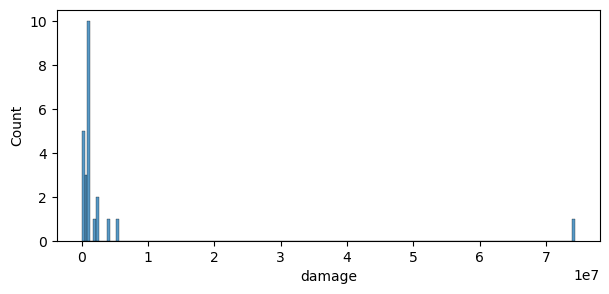

In [67]:
fig, ax = plt.subplots(1,1,figsize=(7, 3))

sns.histplot(data=damage_results,x='damage',ax=ax)

Plot location of most damaged healthcare facilities

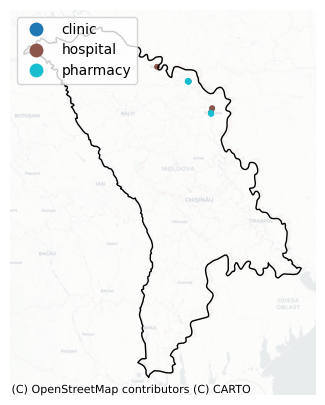

In [68]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))

subset = damage_results.to_crs(3857).sort_values('damage',ascending=False).head(20)
subset.geometry = subset.centroid
subset.plot(ax=ax,column='object_type',markersize=10,legend=True)
world_plot.loc[world.SOV_A3 == country_iso3].plot(ax=ax,facecolor="none",edgecolor='black')
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

In [69]:
viz(damage_results)

Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…